# Problem
The new test for solving pde using pytorch:

$
\frac{\partial{u}}{\partial t} = \kappa (\frac{\partial^2 u}{\partial{x}^2}+\frac{\partial^2 u}{\partial{y}^2}) + S(x,y,t)
$

in the square region $0 \le x \le 2$ and $ 0 \le y \le 2$
for the time $0 \le t \le 2$

Independent variables:
* t - time
* x - coordinate
* y - coordinate

Dependent variables output:
* u - diffusion species

In [1]:
import torch
import torch.nn as nn
from pyDOE import lhs
from collections import OrderedDict
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
#Set default dtype to float32
torch.set_default_dtype(torch.float)


In [4]:
device


device(type='cuda', index=0)

In [59]:
batch_size = 4096*4
block_size = 8
batch_size * block_size
Nc = 256*256

In [60]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
        # create samples using  latin cube sampling
        self.x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * lhs(self.dim, Nc)
        self.y = self.func(self.x)

    def sample(self, N):
        ix = np.random.randint(Nc, size=(N,))
        x = self.x[ix]
        y = self.y[ix]
        return x, y

In [61]:
def u(x, a_1, a_2):
        return np.sin(a_1 * np.pi * x[:, 0:1]) * np.sin(a_2 * np.pi * x[:, 1:2])
def ub(x):
    return np.ones((x.shape[0],1))*300.

def zero_fun(x):
    return np.zeros((x.shape[0],1))


In [62]:

y_min=0.0; y_max = 0.1; x_min = 0.0; x_max = 0.1;

bc1_coords = np.array([[x_min, y_min, 0.0],
                    [x_max, y_min, 1.0]], dtype='float32')
bc2_coords = np.array([[x_max, y_min, 0.0],
                    [x_max, y_max, 1.0]],dtype='float32')
bc3_coords = np.array([[x_max, y_max, 0.0],
                    [x_min, y_max, 1.0]],dtype='float32')
bc4_coords = np.array([[x_min, y_max, 0.0],
                    [x_min, y_min, 1.0]],dtype='float32')

dom_coords = np.array([[x_min, y_min, 0.0],
                       [x_max, y_max, 1.0]],dtype='float32')

bc1 = Sampler(3, bc1_coords, lambda x: ub(x), name='Dirichlet BC1')
bc2 = Sampler(3, bc2_coords, lambda x: ub(x), name='Dirichlet BC1')
bc3 = Sampler(3, bc3_coords, lambda x: ub(x), name='Dirichlet BC1')
bc4 = Sampler(3, bc4_coords, lambda x: ub(x), name='Dirichlet BC1')
bcs_sampler = [bc1,bc2,bc3,bc4]

res_sampler = Sampler(3, dom_coords, lambda x: zero_fun(x), name='Zero condition')

In [63]:
bc3.sample(10)[0]


array([[0.00621981, 0.1       , 0.28954691],
       [0.05639128, 0.1       , 0.98275485],
       [0.04268777, 0.1       , 0.18918034],
       [0.05588144, 0.1       , 0.53581425],
       [0.05325031, 0.1       , 0.72251908],
       [0.0322075 , 0.1       , 0.17758534],
       [0.03900185, 0.1       , 0.65530719],
       [0.09131813, 0.1       , 0.01197478],
       [0.03318982, 0.1       , 0.41260541],
       [0.0971336 , 0.1       , 0.57403607]])

## New layer architecture (Giulio)


In [64]:
class ComplexHeatEquationNet(torch.nn.Module):
    def __init__(self):
        super(ComplexHeatEquationNet, self).__init__()
        self.fc1 = torch.nn.Linear(3, 512)
        self.ln1 = torch.nn.LayerNorm(512)
        self.silu1 = torch.nn.SiLU()
        self.fc2 = torch.nn.Linear(512, 256)
        self.ln2 = torch.nn.LayerNorm(256)
        self.silu2 = torch.nn.SiLU()
        self.fc3 = torch.nn.Linear(256, 128)
        self.ln3 = torch.nn.LayerNorm(128)
        self.silu3 = torch.nn.SiLU()
        self.fc4 = torch.nn.Linear(128, 64)
        self.ln4 = torch.nn.LayerNorm(64)
        self.silu4 = torch.nn.SiLU()
        self.fc5 = torch.nn.Linear(64, 32)
        self.ln5 = torch.nn.LayerNorm(32)
        self.silu5 = torch.nn.SiLU()
        self.fc6 = torch.nn.Linear(32, 1)

    def forward(self, X):
        #print(f"shape X: {X.shape}")
        x = self.silu1(self.ln1(self.fc1(X)))
        x = self.silu2(self.ln2(self.fc2(x)))
        x = self.silu3(self.ln3(self.fc3(x)))
        x = self.silu4(self.ln4(self.fc4(x)))
        x = self.silu5(self.ln5(self.fc5(x)))
        x = self.fc6(x)
        return x

In [65]:
class ComplexHeatEquationNetNew(torch.nn.Module):
    def __init__(self):
        super(ComplexHeatEquationNetNew, self).__init__()
        self.fc1 = torch.nn.Linear(3, 512)
        self.fc2 = torch.nn.Linear(512, 2048)
        self.fc3 = torch.nn.Linear(2048, 1024)
        self.fc4 = torch.nn.Linear(1024, 512)
        self.fc5 = torch.nn.Linear(512, 2048)
        self.fc6 = torch.nn.Linear(2048, 1024)
        self.fc7 = torch.nn.Linear(1024, 512)
        self.fc8 = torch.nn.Linear(512, 1)

        # Xavier initialization
        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        torch.nn.init.xavier_normal_(self.fc3.weight)
        torch.nn.init.xavier_normal_(self.fc4.weight)
        torch.nn.init.xavier_normal_(self.fc5.weight)
        torch.nn.init.xavier_normal_(self.fc6.weight)
        torch.nn.init.xavier_normal_(self.fc7.weight)
        torch.nn.init.xavier_normal_(self.fc8.weight)
        
        # Zero initialization
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.zeros_(self.fc2.bias)
        torch.nn.init.zeros_(self.fc3.bias)
        torch.nn.init.zeros_(self.fc4.bias)
        torch.nn.init.zeros_(self.fc5.bias)
        torch.nn.init.zeros_(self.fc6.bias)
        torch.nn.init.zeros_(self.fc7.bias)
        torch.nn.init.zeros_(self.fc8.bias)

    def forward(self, X):
        x = torch.nn.SiLU()(self.fc1(X)) #512
        
        # Residual block 1
        x1 = torch.nn.SiLU()(self.fc2(x)) #1024
        x2 = torch.nn.SiLU()(self.fc3(x1)) #2048
        x2 = self.fc4(x2)  # note: no activation here #512
        x = x + x2         #512
        
        # Residual block 2
        x1 = torch.nn.SiLU()(self.fc5(x)) #1024
        x2 = torch.nn.SiLU()(self.fc6(x1)) #2048
        x2 = self.fc7(x2)  # note: no activation here #512
        x = x + x2
        
        return self.fc8(x)


Material properties for this case:

In [66]:
ρ = 7860; Cp = 624; k = 30.1
γ = 2.5e+4; P = 1e+5; r0 = 0.005; 
κ = k/(ρ * Cp)
T0 = 300.0

Differential model for this equation is very similar as for one-dimensional case.
* predict out based on the coordinates $x, y$ and time $t$.

In [67]:
learn_rate = 0.01
class Net:
    def __init__(self, ics_sampler, bcs_sampler, res_sampler):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        #device = 'cpu'
        # build model
        # self.model = DiffNet(
        #        input_size=3,
        #        hidden_size=128,
        #        output_size=1,
        #        depth=5,
        #        act=torch.nn.Tanh).to(device)
        self.model = ComplexHeatEquationNetNew().to(device)
        
        # Samplers
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler
        
        self.mse_cost_function = nn.MSELoss()
        self.optimizer = torch.optim.LBFGS(self.model.parameters(),lr=learn_rate,max_iter=500,max_eval=50000,
                                  history_size=50,tolerance_grad=1e-5,tolerance_change=1.0 * np.finfo(float).eps)
        self.optimizer_Adam = torch.optim.Adam(self.model.parameters())
        self.isLBFGS = False
        self.iter = 0
        
    def source(self): 
        return 1.0/(ρ * Cp)* 2*P/(torch.pi*r0**2)*torch.exp(-2/(r0**2)*((self.X[:,0]-self.X[:,2]*0.02)**2 + (self.X[:,1]-y_max/2)**2))

    def f(self):
        u = self.model(self.X) 
        #print(f"u: {u.shape}")    
        u_dX = torch.autograd.grad(
            u, self.X, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = u_dX[:,0]
        u_y = u_dX[:,1]
        u_t = u_dX[:,2]
        
        u_dXX = torch.autograd.grad(
            u_dX, self.X, 
            grad_outputs=torch.ones_like(u_dX),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = u_dXX[:,0]
        u_yy = u_dXX[:,1]
        
        return u_t - κ*u_xx - κ*u_yy - self.source()
    
    def loss_func(self):
        
        if self.isLBFGS: 
            self.optimizer.zero_grad()
        else:
            self.optimizer_Adam.zero_grad()
    
        # initial and boundary conditions
        out = self.model(self.bc_train)
        mse_u = self.mse_cost_function(out, self.u_train)
        
        # fix condition for PDE
        out = self.f()
        mse_f = self.mse_cost_function(out, torch.zeros_like(out))
    
        #loss = mse_u + mse_u_xmax + mse_u_xmin + mse_u_ymax + mse_u_ymin + mse_f
        loss = mse_f + mse_u
        #loss = mse_f
        loss.backward()
        
        if self.iter % 100 == 0:
            print(f" Iter: {self.iter}, loss:{loss.data}")
            
        self.iter += 1
        return loss
    
    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        #X = (X - self.mu_X) / self.sigma_X
        return X, Y
    
    def train(self,epochs, batch_size):
        for epoch in range(epochs):
            # fetch boundary mini-batches
            x_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
            x_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)
            x_bc3_batch, u_bc3_batch = self.fetch_minibatch(self.bcs_sampler[2], batch_size)
            x_bc4_batch, u_bc4_batch = self.fetch_minibatch(self.bcs_sampler[3], batch_size)
            bc_train = [x_bc1_batch,x_bc2_batch,x_bc3_batch,x_bc4_batch]
            u_train  = [u_bc1_batch,u_bc2_batch,u_bc3_batch,u_bc4_batch]
            self.bc_train = torch.cat([torch.from_numpy(bc).float() for bc in bc_train])
            self.u_train  = torch.cat([torch.from_numpy(t).float() for t in u_train])
            
            self.u_train  = self.u_train.to(device)
            self.bc_train = self.bc_train.to(device)
            
            X_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size) 
            self.X = torch.from_numpy(X_batch).float()
            self.X = self.X.to(device)
            
            self.X.requires_grad = True
            
            self.optimizer_Adam.step(self.loss_func)
            
        self.isLBFGS = True
        self.optimizer.step(self.loss_func)

In [68]:
net = Net(None, bcs_sampler, res_sampler)
net.train(1000,batch_size)

 Iter: 0, loss:90504.296875
 Iter: 100, loss:510.1492614746094
 Iter: 200, loss:427.8199768066406
 Iter: 300, loss:483.47161865234375
 Iter: 400, loss:557.33642578125
 Iter: 500, loss:485.9374084472656
 Iter: 600, loss:537.3226318359375
 Iter: 700, loss:560.4596557617188
 Iter: 800, loss:553.2643432617188
 Iter: 900, loss:582.5886840820312
 Iter: 1000, loss:436.0527648925781
 Iter: 1100, loss:435.9846496582031
 Iter: 1200, loss:434.8219299316406
 Iter: 1300, loss:434.5201416015625
 Iter: 1400, loss:433.52716064453125


In [71]:
net.train(5000,batch_size)

 Iter: 3000, loss:456.8570251464844
 Iter: 3100, loss:495.1327209472656
 Iter: 3200, loss:387.49273681640625
 Iter: 3300, loss:414.8277893066406
 Iter: 3400, loss:472.541015625
 Iter: 3500, loss:65860.8984375
 Iter: 3600, loss:66312.4375
 Iter: 3700, loss:36491.6640625
 Iter: 3800, loss:3042.016357421875
 Iter: 3900, loss:1468.8406982421875
 Iter: 4000, loss:1063.5675048828125
 Iter: 4100, loss:984.1660766601562
 Iter: 4200, loss:865.016357421875
 Iter: 4300, loss:810.1973876953125
 Iter: 4400, loss:623.710205078125
 Iter: 4500, loss:611.39453125
 Iter: 4600, loss:640.5203857421875
 Iter: 4700, loss:602.2079467773438
 Iter: 4800, loss:628.8502807617188
 Iter: 4900, loss:709.0476684570312
 Iter: 5000, loss:563.6091918945312
 Iter: 5100, loss:897.3350219726562
 Iter: 5200, loss:400.3477783203125
 Iter: 5300, loss:572.7910766601562
 Iter: 5400, loss:551.1687622070312
 Iter: 5500, loss:547.2655029296875
 Iter: 5600, loss:475.9059753417969
 Iter: 5700, loss:561.2360229492188
 Iter: 5800, lo

In [45]:
net.source()

tensor([  87.3495,   17.1328,    2.2328,  ...,  300.4448,   68.8704,
        1259.1094], device='cuda:0', grad_fn=<MulBackward0>)

shape: (21, 21, 21)


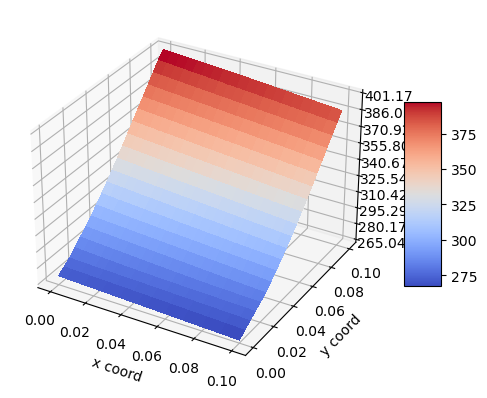

In [72]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = plt.axes(projection='3d')
dx = 0.005
x = torch.arange(0,0.1+dx,dx)
y = torch.arange(0,0.1+dx,dx)
t = torch.ones_like(x)*2
X = torch.stack(torch.meshgrid(x,y,t)).reshape(3,-1).T.to(device)


u_pred = net.model(X)
um = u_pred.data.cpu().numpy()
um = um.reshape(21,21,21)

x = np.arange(0,0.1+dx,dx)
y = np.arange(0,0.1+dx,dx)
xm, ym = np.meshgrid(x,y)

print(f"shape: {um.shape}")

surf = ax.plot_surface(xm, ym, um[:,:,3], cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel("y coord")
ax.set_xlabel("x coord")
fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()

In [ ]:
def solution(x,y,t):
    return np.exp(x + y) * np.cos(x + y + 4*t)
anal_sol = solution(x,y,2)
mse=np.mean((anal_sol-u_pred.data.cpu().numpy())**2)


In [ ]:
mse

In [ ]:
x.shape[0]

In [ ]:
u_pred.shape